In [75]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import os
from PIL import Image
from pickle import dump, load
from sklearn.svm import SVC
from torchvision import transforms


In [76]:
# def load_images(images_folder, save_file_to=None):
    
#     X_original = []
#     X = []
#     y = []
    
#     for subdir, dirs, files in os.walk(images_folder):
#         for file in files:
#             if file.endswith(('jpg', 'jpeg', 'png')):
#                 img_path = os.path.join(subdir, file)
#                 label = os.path.basename(subdir)
                
#                 image = Image.open(img_path).convert('L')
#                 image = image.resize((48, 48))
#                 X_original.append(np.array(image).flatten())
#                 X.append(np.array(image).flatten())
#                 y.append(label)
                
#     if save_file_to:
#         with open(save_file_to, "wb") as f:
#             dump((X_original,X, y), f, protocol=5)
                
#     return np.array(X_original), np.array(X), np.array(y)

# images_folder = '/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/images'
# dataset_file = "/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/dump/dataset_dump.pkl"

# # Load images and save the dataset for reuse
# X_original, X, y = load_images(images_folder, save_file_to=dataset_file)

In [77]:
with open("/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/dump/dataset_dump.pkl", "rb") as f:
    X_original,X,y = load(f)
    
X
y

['happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',


In [78]:
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

In [79]:
# def preprocessing_data(X, y, save_file_to=None):
#     # Normalize pixel values
#     X = X / 255.0  # Normalize to [0, 1]
    
#     # Encode labels
#     label_encoder = LabelEncoder()
#     y_encoded = label_encoder.fit_transform(y)
    
#     # Dimensionality reduction with PCA
#     pca = PCA(n_components=100)
#     X_reduced = pca.fit_transform(X)
    
    # # Standardize the data
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X_reduced)
    
#     if save_file_to:
#         with open(save_file_to, "wb") as f:
#             dump((X_scaled, y_encoded, label_encoder, pca, scaler), f, protocol=5)
    
#     return X_scaled, y_encoded, label_encoder, pca, scaler

# X_scaled, y_encoded, label_encoder, pca, scaler = preprocessing_data(X, y, save_file_to="/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/dump/labelencoder_standardscaler_pca_normalizers_dump.pkl")

# # with open("svc_standardscaler_gridsearch_normalizers_dump.pkl", "wb") as f:
# #     dump((label_encoder, pca, scaler), f, protocol=5)

In [80]:
with open("/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/dump/labelencoder_standardscaler_pca_normalizers_dump.pkl", "rb") as f:
    X_scaled, y_encoded, label_encoder, pca, scaler = load(f)

In [81]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [82]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [83]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, len(np.unique(y_encoded)))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [84]:
# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [85]:
# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 1.9539
Epoch [2/1000], Loss: 1.9447
Epoch [3/1000], Loss: 1.9358
Epoch [4/1000], Loss: 1.9272
Epoch [5/1000], Loss: 1.9188
Epoch [6/1000], Loss: 1.9106
Epoch [7/1000], Loss: 1.9028
Epoch [8/1000], Loss: 1.8951
Epoch [9/1000], Loss: 1.8877
Epoch [10/1000], Loss: 1.8805
Epoch [11/1000], Loss: 1.8736
Epoch [12/1000], Loss: 1.8668
Epoch [13/1000], Loss: 1.8602
Epoch [14/1000], Loss: 1.8538
Epoch [15/1000], Loss: 1.8475
Epoch [16/1000], Loss: 1.8414
Epoch [17/1000], Loss: 1.8355
Epoch [18/1000], Loss: 1.8296
Epoch [19/1000], Loss: 1.8239
Epoch [20/1000], Loss: 1.8184
Epoch [21/1000], Loss: 1.8129
Epoch [22/1000], Loss: 1.8075
Epoch [23/1000], Loss: 1.8023
Epoch [24/1000], Loss: 1.7971
Epoch [25/1000], Loss: 1.7920
Epoch [26/1000], Loss: 1.7870
Epoch [27/1000], Loss: 1.7821
Epoch [28/1000], Loss: 1.7773
Epoch [29/1000], Loss: 1.7725
Epoch [30/1000], Loss: 1.7678
Epoch [31/1000], Loss: 1.7632
Epoch [32/1000], Loss: 1.7587
Epoch [33/1000], Loss: 1.7542
Epoch [34/1000], Lo

In [86]:
# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 45.57%


In [87]:
# Save the model
torch.save(model.state_dict(), "simple_nn_model.pth")
print("Model saved successfully!")

Model saved successfully!


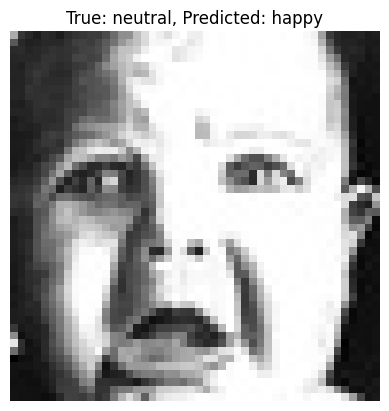

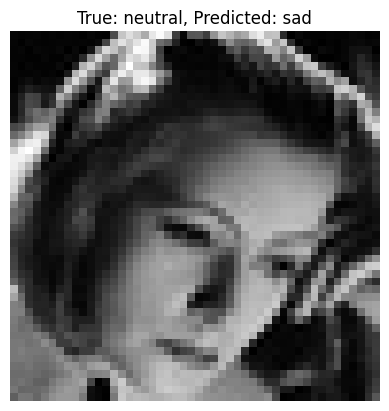

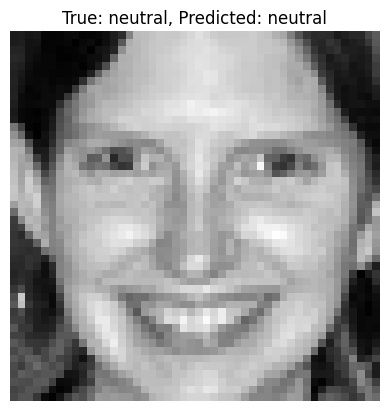

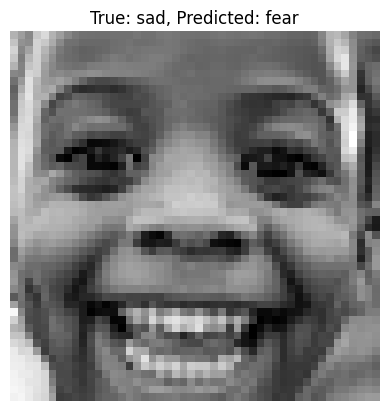

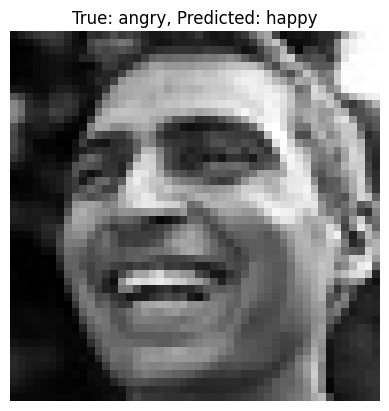

In [88]:
# Visualize predictions
def visualize_predictions(model, X_test, y_test, label_encoder, X_original):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, y_pred = torch.max(outputs.data, 1)
    
    random_indices = np.random.randint(0, len(y_test), 5)
    
    for idx in random_indices:
        original_image = X_original[idx].reshape(48, 48)  # Reshape to 48x48
        plt.imshow(original_image, cmap='gray')
        plt.title(f"True: {label_encoder.inverse_transform([y_test[idx]])[0]}, "
                  f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}")
        plt.axis('off')
        plt.show()

visualize_predictions(model, X_test_tensor, y_test_tensor, label_encoder, X_original)